## Teste

### Reta

In [14]:
# Pacotes
import pybullet as p
import time 
import pybullet_data
from math import pi
import math
from os.path import dirname, join as pjoin
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random
import os 

def perseguição_pura(model, L ,xf, yf):
    '''
    CONTROLE POR PERSEGUIÇÃO PURA PARA um PONTO (xf,yf)
    model = modelo do veículo;
    xf,yf = Ponto final desejada;
    Vv = Velocidade para o veículo (saída);
    Phiv = Ângulo de esterçamento do veículo (saída); 
    L = Distância entre eixos do veículo
    '''
    # Posição e pose do veículo
    world_position, world_orientation = p.getLinkState(model, 0)[:2]
    w = world_orientation[3]
    # Pose do veículo
    thv = math.acos(w)*2 
    if world_orientation[2] != 0:
        thv = thv*world_orientation[2]/(abs(world_orientation[2]))
    # Posição do veículo
    xv = world_position[0] # Posição x do veículo
    yv = world_position[1] # Posição y do veículo
    
    # Dados entre o veículo (xv,yv,thv) e o ponto de referência (xf,yf)
    ld = ((xf-xv)**2 + (yf-yv)**2)**(1/2) # Distância entre o veículo e ponto de referência 
    
    # Alpha
    xf = xf - xv
    yf = yf - yv
    xf2 = xf*math.cos(thv) + yf*math.sin(thv)  
    if xf2 == 0: # Não pode dividir por zero
        xf2 = 0.0000000001
    yf2 = -xf*math.sin(thv) + yf*math.cos(thv)
    a = math.atan2(yf2,xf2)
    
    # Normalizar a 
    if a < -pi:
        a = pi + 2*math.pi
    if a > pi:
        a = pi - 2*math.pi
    
    # Ângulo de esterçamento
    phiv = math.atan2(2*L*math.sin(a),ld)
    
    return phiv  


def geometria_ackermann (model, V, phi, D, L, r, phi_max, dphi):
    # Função que define a velocidade e o ângulo de esterçamento de cada roda 
    # V = velocidade linear do veículo referenciando o modelo do tipo bicicleta, entre eixos traseiro;
    # phi = Ângulo de esterçamento da roda dianteira imaginária central;
    # D = Distância entre as rodas do mesmo eixo;
    # L = Distrância entre os eixos
    # r = Raio da roda do veículo
    # phi_max = Ângulo de esterçamento máximo
    # dphi = Velocidade do ângulo de esterçamento
    
    # Limite do ângulo de esterçamento
    if abs(phi) > phi_max:
        phi = phi/(abs(phi))*phi_max 
    
    # Converter a velocidade V para rad/s
    V = V/r # rad/s
    # if phi == 0:
    #     R = 99999999
    # else:
    #     R = L/(math.tan(phi))
    # phi_1 = math.atan(L/(R+D/2)) # Roda da direita
    # phi_2 = math.atan(L/(R-D/2)) # Roda da esquerda
    # vtd = V*(1+D/(2*R)) # 3
    # vte = V*(1-D/(2*R)) # 2
    # vfd = vtd/(math.cos(phi_1)) # 7
    # vfe = vte/(math.cos(phi_2)) # 5
    
    vtd = V
    vte = V
    vfd = V
    vfe = V
    
    # Torque
    T = 1
    
    # Velocidade
    # vfd
    p.setJointMotorControl2(model,7,p.VELOCITY_CONTROL,force=T,targetVelocity=vfd)

    # vfe
    p.setJointMotorControl2(model,5,p.VELOCITY_CONTROL,force=T,targetVelocity=vfe)

    # vtd
    p.setJointMotorControl2(model,3,p.VELOCITY_CONTROL,force=T,targetVelocity=vtd)

    # vte
    p.setJointMotorControl2(model,2,p.VELOCITY_CONTROL,force=T,targetVelocity=vte)
    
    # Ângulo de esterçamento
    # phi_1
    # p.setJointMotorControl2(model,6, p.POSITION_CONTROL,maxVelocity=dphi,targetPosition = phi_1)
    # # phi_2
    # p.setJointMotorControl2(model,4, p.POSITION_CONTROL,maxVelocity=dphi,targetPosition = phi_2)

V = 1  # Velocidade
L = 1  # Comprimento do carro
R = L / math.tan(math.pi / 8)  # Raio de curvatura
dtheta = V / R  # Velocidade angular
step = 0.0001  # Intervalo da simulação

# Condições iniciais:
x = [0]
y = [0]
th = [0]

# Dados do veículo:
rr = 0.05 # Raio da roda
D = 0.2 # Distância entre as rodas do mesmo eixo
L = 0.325 # Distância entre eixos 
B = 290/1000
f = 100/1000
l =  50/1000
A = l + f + L
phi_max = pi/6 # Ângulo de esterçamento máximo do veículo
dphi = 1 # Velocidade máxima do ângulo de esterçamento
# https://github.com/bulletphysics/bullet3/blob/master/data/racecar/racecar.urdf

# ================ Plano e Ambiente ================ #
p.connect(p.GUI)  # or p.DIRECT for non-graphical version
p.resetSimulation() # Reset
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Referência dos arquivos URDF
plane = p.loadURDF("plane.urdf") # Adiciona um plano
p.setGravity(0, 0, -9.81) # Gravidade (x,y,z)
step = 0.0001 # Intervalo da simulação 
p.setTimeStep(step) # time step
p.setRealTimeSimulation(0) # Retorna o tempo em zero

# ================ Robô ================ #
carro = p.loadURDF("racecar/racecar.urdf",[0, 0, 0.01],useFixedBase=0) # Posição

# Condições iniciais
position, orientation = p.getLinkState(carro, 0)[:2] # Dados espaciais da referência

xv2 = [position[0]]
yv2 = [position[0]]

# Ângulo de esterçamento
geometria_ackermann (carro, 0, pi/8, D, L, rr, phi_max, dphi)
for _ in range(10):
    p.stepSimulation() 
    
# Ângulo de esterçamento
geometria_ackermann (carro, V, pi/8, D, L, rr, phi_max, dphi)
for _ in range(50000):
    p.stepSimulation() 
    position, orientation = p.getLinkState(carro, 0)[:2] # Dados espaciais da referência
    xv2.append(position[0])
    yv2.append(position[1])

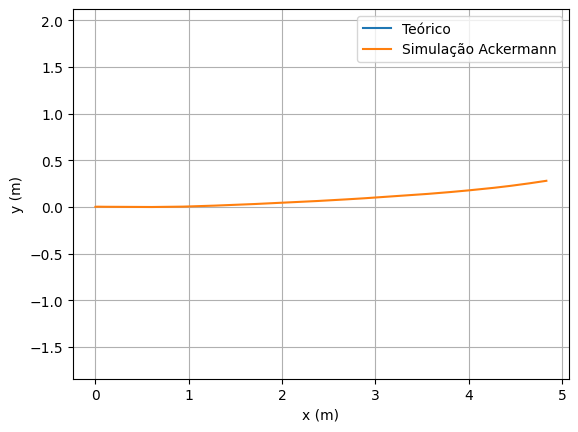

In [16]:
# Gráfico
plt.plot(x,y, label = 'Teórico')
plt.plot(xv2,yv2, label = 'Simulação Ackermann')
plt.axis('equal')
plt.legend(loc = 'upper right')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.show()

### reta 2

In [8]:
import pybullet as p
import time 
import pybullet_data
from math import pi, atan2, sqrt, tan, cos, sin
import math
import numpy as np
import matplotlib.pyplot as plt

def geometria_ackermann(model, V, phi, D, L, r, phi_max, dphi):
    # Função que define a velocidade e o ângulo de esterçamento de cada roda
    # V = velocidade linear do veículo referenciando o modelo do tipo bicicleta, entre eixos traseiro;
    # phi = Ângulo de esterçamento da roda dianteira imaginária central;
    # D = Distância entre as rodas do mesmo eixo;
    # L = Distância entre os eixos
    # r = Raio da roda do veículo
    # phi_max = Ângulo de esterçamento máximo
    # dphi = Velocidade do ângulo de esterçamento

    # Limite do ângulo de esterçamento
    if abs(phi) > phi_max:
        phi = phi/(abs(phi))*phi_max

    # Converter a velocidade V para rad/s
    V = V/r # rad/s
    
    # Ângulo de esterçamento das rodas dianteiras
    if phi == 0:
        phi_1 = 0
        phi_2 = 0
    else:
        R = L/tan(phi)
        phi_1 = atan2(L, R+D/2)
        phi_2 = atan2(L, R-D/2)

    # Velocidades das rodas
    vtd = V*(1+D/(2*R)) # Roda da direita traseira
    vte = V*(1-D/(2*R)) # Roda da esquerda traseira
    vfd = vtd/cos(phi_1) # Roda da direita dianteira
    vfe = vte/cos(phi_2) # Roda da esquerda dianteira

    # Torque
    T = 1

    # Velocidade
    p.setJointMotorControl2(model, 3, p.VELOCITY_CONTROL, force=T, targetVelocity=vtd)
    p.setJointMotorControl2(model, 2, p.VELOCITY_CONTROL, force=T, targetVelocity=vte)
    p.setJointMotorControl2(model, 7, p.VELOCITY_CONTROL, force=T, targetVelocity=vfd)
    p.setJointMotorControl2(model, 5, p.VELOCITY_CONTROL, force=T, targetVelocity=vfe)


# Dados do veículo:
rr = 0.05 # Raio da roda
D = 0.2 # Distância entre as rodas do mesmo eixo
L = 0.325 # Distância entre eixos
phi_max = pi/6 # Ângulo de esterçamento máximo do veículo
dphi = 1 # Velocidade máxima do ângulo de esterçamento

# Configuração inicial
x_initial = 0  # Posição inicial x
y_initial = 0  # Posição inicial y
directions = [(2, 3), (4, 5), (1, -1)]  # Array de direções (x, y)

# ================ Plano e Ambiente ================ #
p.connect(p.GUI)  # Conectar ao ambiente gráfico
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Referência dos arquivos URDF
plane = p.loadURDF("plane.urdf") # Adiciona um plano
p.setGravity(0, 0, -9.81) # Gravidade (x,y,z)
step = 0.0001 # Intervalo da simulação 
p.setTimeStep(step) # time step
p.setRealTimeSimulation(0) # Retorna o tempo em zero

# ================ Robô ================ #
carro = p.loadURDF("racecar/racecar.urdf",[0, 0, 0.01],useFixedBase=0) # Posição

# Condições iniciais
position, _ = p.getBasePositionAndOrientation(carro) # Dados espaciais da referência
x = [position[0]]
y = [position[1]]

# Iterar sobre as direções e mover o veículo
for direction in directions:
    x_final, y_final = direction
    
    # Cálculo da direção e velocidade
    delta_x = x_final - x_initial
    delta_y = y_final - y_initial
    phi = atan2(delta_y, delta_x)
    V = sqrt(delta_x**2 + delta_y**2)
    
    # Ângulo de esterçamento
    geometria_ackermann(carro, V, phi, D, L, rr, phi_max, dphi)
    
    # Simulação
    for _ in range(500):
        p.stepSimulation() 
        position, _ = p.getBasePositionAndOrientation(carro) # Dados espaciais da referência
        x.append(position[0])
        y.append(position[1])
    
    # Atualizar posição inicial para a próxima direção
    x_initial = x_final
    y_initial = y_final

error: Not connected to physics server.

In [ ]:
p.resetSimulation() # Reset

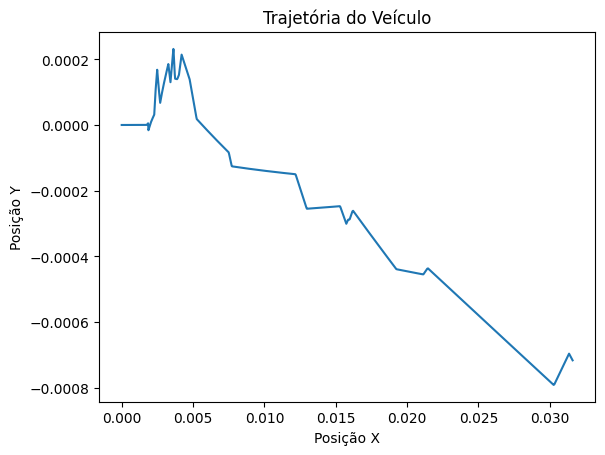

In [ ]:
# Plotar trajetória
plt.plot(x, y)
plt.xlabel('Posição X')
plt.ylabel('Posição Y')
plt.title('Trajetória do Veículo')
plt.show()

### TEST

In [ ]:
# Pacotes
import pybullet as p
import time 
import pybullet_data
from math import pi
import math
from os.path import dirname, join as pjoin
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [ ]:
def perseguição_pura(model, L ,xf, yf, reta):
    '''
    CONTROLE POR PERSEGUIÇÃO PURA PARA um PONTO (xf,yf)
    model = modelo do veículo;
    xf,yf = Ponto final desejada;
    Vv = Velocidade para o veículo (saída);
    Phiv = Ângulo de esterçamento do veículo (saída); 
    L = Distância entre eixos do veículo
    '''
    # Posição e pose do veículo
    world_position, world_orientation = p.getLinkState(model, 0)[:2]
    w = world_orientation[3]
    # Pose do veículo
    thv = math.acos(w)*2 
    if world_orientation[2] != 0:
        thv = thv*world_orientation[2]/(abs(world_orientation[2]))
    # Posição do veículo
    xv = world_position[0] # Posição x do veículo
    yv = world_position[1] # Posição y do veículo
    
    # Dados entre o veículo (xv,yv,thv) e o ponto de referência (xf,yf)
    ld = ((xf-xv)**2 + (yf-yv)**2)**(1/2) # Distância entre o veículo e ponto de referência 
    
    # Alpha
    xf = xf - xv
    yf = yf - yv
    xf2 = xf*math.cos(thv) + yf*math.sin(thv)  
    if xf2 == 0: # Não pode dividir por zero
        xf2 = 0.0000000001
    yf2 = -xf*math.sin(thv) + yf*math.cos(thv)
    a = math.atan2(yf2,xf2)
    
    # Normalizar a 
    if a < -pi:
        a = pi + 2*math.pi
    if a > pi:
        a = pi - 2*math.pi
    
    # Ângulo de esterçamento
    if reta:
        phiv = 0
    else:    
        phiv = math.atan2(2*L*math.sin(a),ld)
    
    return phiv  

def geometria_ackermann(model, V, phi, D, L, r, phi_max, dphi, reta):
    # Função que define a velocidade de cada roda para uma trajetória em linha reta
    # V = velocidade linear do veículo referenciando o modelo do tipo bicicleta, entre eixos traseiro;
    # D = Distância entre as rodas do mesmo eixo;
    # L = Distância entre os eixos
    # r = Raio da roda do veículo

    # Converter a velocidade V para rad/s
    V = V / r  # rad/s

    if reta:
        vtd = V
        vte = V
        vfd = V
        vfe = V
    
    else:
        # Limite do ângulo de esterçamento
        if abs(phi) > phi_max:
            phi = phi/(abs(phi))*phi_max 

        if phi == 0:
            R = 99999999
        else:
            R = L/(math.tan(phi))
            phi_1 = math.atan(L/(R+D/2)) # Roda da direita
            phi_2 = math.atan(L/(R-D/2)) # Roda da esquerda
            vtd = V*(1+D/(2*R)) # 3
            vte = V*(1-D/(2*R)) # 2
            vfd = vtd/(math.cos(phi_1)) # 7
            vfe = vte/(math.cos(phi_2)) # 5
    # Torque
    T = 1
    
    # Velocidade
    # vfd
    p.setJointMotorControl2(model, 7, p.VELOCITY_CONTROL, force=T, targetVelocity=vfd)

    # vfe
    p.setJointMotorControl2(model, 5, p.VELOCITY_CONTROL, force=T, targetVelocity=vfe)

    # vtd
    p.setJointMotorControl2(model, 3, p.VELOCITY_CONTROL, force=T, targetVelocity=vtd)

    # vte
    p.setJointMotorControl2(model, 2, p.VELOCITY_CONTROL, force=T, targetVelocity=vte)

    # Ângulo de esterçamento
    if not reta:
        # phi_1
        p.setJointMotorControl2(model,6, p.POSITION_CONTROL,maxVelocity=dphi,targetPosition = phi_1)
        # phi_2
        p.setJointMotorControl2(model,4, p.POSITION_CONTROL,maxVelocity=dphi,targetPosition = phi_2)

In [ ]:
# Dados do veículo:
rr = 0.05 # Raio da roda
D = 0.2 # Distância entre as rodas do mesmo eixo
L = 0.325 # Distância entre eixos 
B = 290/1000
f = 100/1000
l =  50/1000
A = l + f + L
phi_max = pi/6 # Ângulo de esterçamento máximo do veículo
dphi = 1 # Velocidade máxima do ângulo de esterçamento
# https://github.com/bulletphysics/bullet3/blob/master/data/racecar/racecar.urdf

In [ ]:
#TEORICO
V = 1 # Velocidade 
R = L/math.tan(pi/8) # Raio de curvatura
dtheta = V/R  # Velocidade ângular 
step = 0.0001 # Intervalo da simulação  

# Condições iniciais:
x  = [0]
y  = [0]
th = [0]

contador = 0
reta = True  # Indica que a trajetória é uma reta inicialmente
retas = [0]
test = random.randint(1,10)

# Tempo discreto
for i in range(500000):
    retas.append(reta) 
    if reta:
        th.append(th[i]) # theta[i]
        dx = V*math.cos(th[i]) + 0.1        # dx[i]
        dy = V*math.sin(th[i]) + 0.1       # dy[i]

    else:
        th.append(th[i] + dtheta*step) # theta[i]
        dx = V*math.cos(th[i])        # dx[i]
        dy = V*math.sin(th[i])       # dy[i]

    x.append(x[i] + dx*step)       # x[i]
    y.append(y[i] + dy*step)       # y[i]

    contador += 1  # Incrementa o contador a cada execução
    
    if contador == 20000:  # Verifica se já se passaram 100 execuções
        test = random.randint(1,10)
        contador = 0  # Reinicia o contador
        
        if reta:
            reta = False  # Muda para o formato de curva
            
        else:
            reta = True  # Muda para o formato de reta

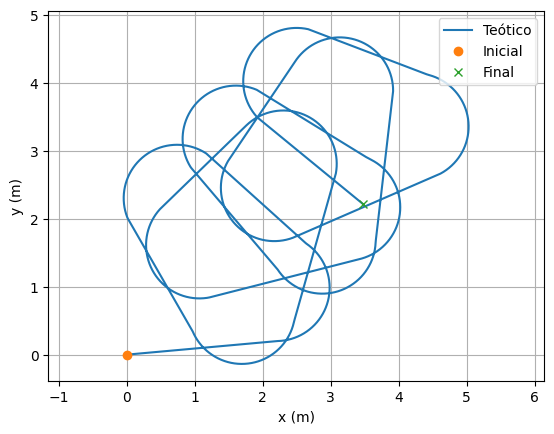

In [ ]:
# Gráfico
plt.plot(x,y, label = 'Teótico')
plt.plot(x[0],y[0],'o',label = 'Inicial')
plt.plot(x[-1],y[-1],'x',label = 'Final')
plt.axis('equal')
plt.legend(loc = 'upper right')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.show()

In [ ]:
p.connect(p.GUI)  # or p.DIRECT for non-graphical version

0

In [ ]:
# ================ Plano e Ambiente ================ #
p.resetSimulation() # Reset
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Referência dos arquivos URDF
plane = p.loadURDF("plane.urdf") # Adiciona um plano
p.setGravity(0, 0, -9.81) # Gravidade (x,y,z)
step = 0.0001 # Intervalo da simulação 
p.setTimeStep(step) # time step
p.setRealTimeSimulation(0) # Retorna o tempo em zero

# ================ Robô ================ #
carro = p.loadURDF("racecar/racecar.urdf",[0, 0, 0.01],useFixedBase=0) # Posição

# Condições iniciais
position, orientation = p.getLinkState(carro, 0)[:2] # Dados espaciais da referência

xvp = [position[0]]
yvp = [position[0]]
phiv = [pi/8]

# Ângulo de esterçamento
geometria_ackermann (carro, 0, pi/8, D, L, rr, phi_max, dphi, retas[0])
for _ in range(10):
    p.stepSimulation() 

Lda = 0.45
Lreta=0.0003
for i in range(len(x)):
    xf = x[i] # Referência em x
    yf = y[i] # Referência em y
    position, orientation = p.getLinkState(carro, 0)[:2] # Dados espaciais da referência
    D = ((position[0] - xf)**2 + (position[1] - yf)**2)**(1/2) # Mede a distância entre o veículo e o ponto de referência
    while D > Lda and not retas[i]: # Equanto a distância mínima não for alcançada, segue-se com o mesmo referencial
        phic = perseguição_pura(carro, L, xf, yf, retas[i]) # Controle de perseguição pura 
        geometria_ackermann (carro, V, phic, D, L, rr, phi_max, dphi, retas[i]) # Modelo geometria ackermann
        phiv.append(phic)
        p.stepSimulation()
        position, orientation = p.getLinkState(carro, 0)[:2] # Dados espaciais da referência
        xvp.append(position[0])
        yvp.append(position[1])
        D = ((position[0] - xf)**2 + (position[1] - yf)**2)**(1/2)

    if retas[i]:
        p.stepSimulation() 
        position, orientation = p.getLinkState(carro, 0)[:2] # Dados espaciais da referência
        xvp.append(position[0])
        yvp.append(position[1])


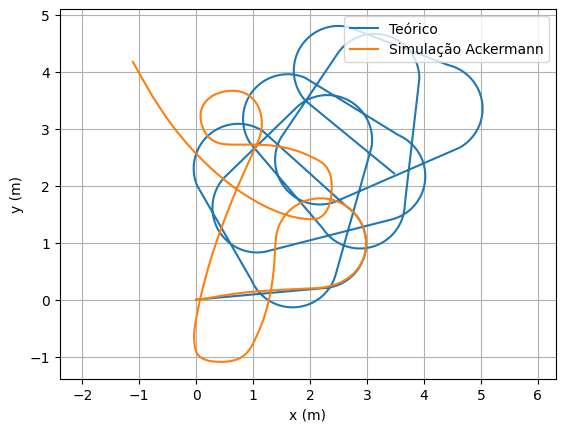

In [ ]:
# Gráfico
plt.plot(x,y, label = 'Teórico')
plt.plot(xvp,yvp, label = 'Simulação Ackermann')
plt.axis('equal')
plt.legend(loc = 'upper right')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.show()